<div style="text-align: center; color: #ffffff; font-family: Babas; font-size: 3em;">01. GRABEN - MONTESANTO</div>
<div style="text-align: left; color: #ffffff; font-family: Babas; font-size: 2.5em;">DESCRIPCIÓN</div>
<div style="text-align: left; color: #ffffff; font-family: Babas; font-size: 2em; border-bottom: 1px solid white;">Información obtenida de un corte geológico suroeste-noreste, ubicado en la plancha 39 – El Difícil. El modelo muestra un graben ocasionado por la falla normal Montesanto y otra falla que no aflora en superficie.  Este movimiento extensional afecta a las formaciones sedimentarias (areniscas) de Zambrano (N2z), Jesús del Monte (N1jm) compuesta por lodolitas, Rancho (N1r) y Ciénaga de Oro (E3N1co).  </div>

In [1]:
import gempy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pyvista
import warnings
import pickle
from discretize.utils import mkvc, active_from_xyz
from discretize import TensorMesh

Setting Backend To: AvailableBackends.numpy


In [2]:
import pickle
import gempy as gp  # important to have GemPy imported before unpickling

path = r"D:\PT_981\9081\modelamiento\models\graben_VIM.p"
# or: "D:\\PT_981\\9081\\modelamiento\\models\\graben_VIM.p"

with open(path, "rb") as f:
    modelo = pickle.load(f)

print(type(modelo))

<class 'gempy.core.data.geo_model.GeoModel'>


# B. ASSIGNMENT OF GEOPHYSICAL PROPERTIES

## Magnetotellurics


Usando estas columnas como X, Y, Z: ['ID', 'X_m', 'Y_m', 'Z_m']


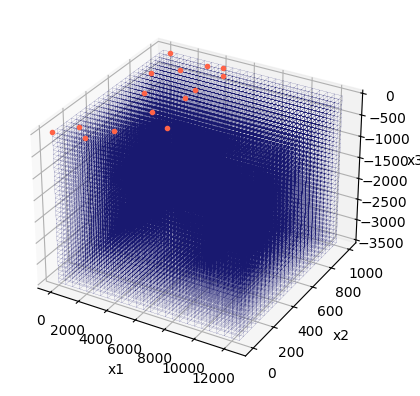

In [3]:
#import pandas as pd
#import numpy as np

# leer archivo
datos = pd.read_csv(r"D:\PT_981\9081\modelamiento\models\topografia_15_puntos.csv", sep=',')

# tomar las primeras 3 columnas (X, Y, Z) — comprobar que existan
columnas = datos.columns.tolist()[:4]
if len(columnas) < 3:
    raise ValueError(f"Se esperaban al menos 3 columnas (X,Y,Z). Columnas encontradas: {len(columnas)} -> {datos.columns.tolist()}")

print(f"\nUsando estas columnas como X, Y, Z: {columnas}")

# usar índices 0,1,2 (no 1,2,3)
x_topo = datos[columnas[1]].values
y_topo = datos[columnas[2]].values
z_topo = datos[columnas[3]].values
topo_xyz = np.column_stack((x_topo, y_topo, z_topo))

dx = 500
ncx = 25
dy = 40
ncy = 25
dz = 100
ncz = 35


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
grid = TensorMesh([hx, hy, hz], x0=[0,0,-3500])
# cell_centers = meshes.cell_centers
# xy_ravel=cell_centers
                           
grid.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x_topo, y_topo, z_topo, '.', color='tomato')

In [4]:
sol_block = gp.compute_model_at(modelo, grid.gridCC)

Active grids: GridTypes.CUSTOM|NONE
Setting Backend To: AvailableBackends.numpy


c:\Users\torre\anaconda3\envs\mods\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


Chunking done: 8 chunks
Chunking done: 12 chunks


c:\Users\torre\anaconda3\envs\mods\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))
c:\Users\torre\anaconda3\envs\mods\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import discretize
from simpeg import utils
from simpeg.electromagnetics import natural_source as NSEM
from simpeg import maps


In [6]:

# ========================================
# 1. Leer topografía
# ========================================
datos = pd.read_csv(r"D:\PT_981\9081\modelamiento\models\topografia_15_puntos.csv", sep=',')
columnas = datos.columns.tolist()[:4]
if len(columnas) < 3:
    raise ValueError(f"Se esperaban al menos 3 columnas (X,Y,Z). Columnas encontradas: {len(columnas)} -> {datos.columns.tolist()}")

x_topo = datos[columnas[1]].values
y_topo = datos[columnas[2]].values
z_topo = datos[columnas[3]].values
topo_xyz = np.column_stack((x_topo, y_topo, z_topo))

# ========================================
# 2. Crear la malla (igual que gravimetría)
# ========================================
dx = 400
ncx = 25
dy = 40
ncy = 25
dz = 100
ncz = 35

hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
mesh = discretize.TensorMesh([hx, hy, hz], x0=[0,0,-3500])

# ========================================
# 3. Definir bloque de propiedades MT
# ========================================
# Usando los mismos bloques de litología que en gravimetría
block_min = np.array([-100, -100, -350])
block_max = np.array([100, 100, -150])



In [7]:
conds = {
    0: 1e-2,  # fondo
    1: 1e-1,  # cuerpo 1
    2: 1e-2,  # cuerpo 2
    3: 1e-1,  # cuerpo 3
    4: 1e-2,  # cuerpo 4
    5: 1e-1   # cuerpo 5
}

# Suponiendo que sol_block es tu modelo de litología
# Crear modelo MT en celdas activas
#from simpeg.utils import active_from_xyz
ind_active = active_from_xyz(grid, topo_xyz)
nC = int(ind_active.sum())
model_mt = np.zeros(nC)

In [ ]:

# Mapear cada litología a sigma
for i, sigma in conds.items():
    ind_lith = sol_block[ind_active] == i
    model_mt[ind_lith] = sigma

# ========================================
# 4. Interpolación de topografía para receptores
# ========================================
from scipy.interpolate import LinearNDInterpolator
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x_topo, y_topo])
rx_loc = np.c_[x_topo, y_topo, z]

# ========================================
# 5. Crear lista de receptores
# ========================================
receiver_list = []
for rx_orientation in ["xx", "xy", "yx", "yy"]:
    receiver_list.append(
        NSEM.receivers.Impedance(rx_loc, orientation=rx_orientation, component="real")
    )
    receiver_list.append(
        NSEM.receivers.Impedance(rx_loc, orientation=rx_orientation, component="imag")
    )
for rx_orientation in ["zx", "zy"]:
    receiver_list.append(
        NSEM.receivers.Tipper(rx_loc, orientation=rx_orientation, component="real")
    )
    receiver_list.append(
        NSEM.receivers.Tipper(rx_loc, orientation=rx_orientation, component="imag")
    )

# ========================================
# 6. Definir fuentes y survey
# ========================================
freqs = np.logspace(4, -2, 3)
source_list = [NSEM.Src.PlanewaveXYPrimary(receiver_list, f) for f in freqs]
survey = NSEM.Survey(source_list)

# ========================================
# 7. Definir problema MT 3D
# ========================================
sigma_map = maps.IdentityMap(nP=nC)
simulation = NSEM.Simulation3DPrimarySecondary(
    mesh=grid,
    survey=survey,
    sigma=model_mt ,
    sigmaPrimary=np.zeros(grid.nC) + 1e-2,
    forward_only=True
)

INFO: Setting the default solver 'SolverLU' for the 'Simulation3DPrimarySecondary'.
To avoid receiving this message, pass a solver to the simulation. For example:

  from simpeg.utils import get_default_solver

  solver = get_default_solver()
  simulation = Simulation3DPrimarySecondary(solver=solver, ...)
c:\Users\torre\anaconda3\envs\mods\Lib\site-packages\simpeg\base\pde_simulation.py:663: PerformanceWarning: The 'pymatsolver.SolverLU' solver might lead to high computation times. We recommend using a faster alternative such as 'pymatsolver.Pardiso' or 'pymatsolver.Mumps'.
  super().__setattr__(name, value)


In [ ]:
# ========================================
# 8. Simulación forward
# ========================================
data = NSEM.Data(survey=survey, dobs=simulation.dpred())
data.relative_error = 0.1
data.noise_floor = 0.0

# ========================================
# 9. Graficar malla, bloque y receptores
# ========================================
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Bloque
x0, y0, z0 = block_min
x1, y1, z1 = block_max
vertices = np.array([[x0,y0,z0],[x1,y0,z0],[x1,y1,z0],[x0,y1,z0],
                     [x0,y0,z1],[x1,y0,z1],[x1,y1,z1],[x0,y1,z1]])
faces = [[0,1,2,3],[4,5,6,7],[0,1,5,4],[2,3,7,6],[1,2,6,5],[0,3,7,4]]
poly = Poly3DCollection([vertices[f] for f in faces], alpha=0.25)
poly.set_edgecolor('k')
ax.add_collection3d(poly)

# Receptores
ax.scatter(rx_loc[:,0], rx_loc[:,1], rx_loc[:,2], c='r', s=20, label='receivers')

# Celdas de malla (subset para no sobrecargar)
subset = np.random.choice(np.arange(mesh.nC), size=min(2000, mesh.nC), replace=False)
ax.scatter(mesh.gridCC[subset,0], mesh.gridCC[subset,1], mesh.gridCC[subset,2], 
           c=np.log10(model_mt[subset]+1e-8), cmap='viridis', s=6)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_xlim(mesh.x0[0], mesh.x0[0]+mesh.h[0].sum())
ax.set_ylim(mesh.x0[1], mesh.x0[1]+mesh.h[1].sum())
ax.set_zlim(mesh.x0[2], mesh.x0[2]+mesh.h[2].sum())
plt.legend()
plt.show()


c:\Users\torre\anaconda3\envs\mods\Lib\site-packages\simpeg\electromagnetics\natural_source\sources.py:77: RuntimeWarning: divide by zero encountered in log
  volume_average(mesh3d, mesh1d, np.log(self._sigma_primary))
c:\Users\torre\anaconda3\envs\mods\Lib\site-packages\simpeg\electromagnetics\natural_source\sources.py:84: RuntimeWarning: divide by zero encountered in log
  volume_average(mesh1d, mesh3d, np.log(self._sigma1d))
c:\Users\torre\anaconda3\envs\mods\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
